In [1]:
import matplotlib as mpl
default_mpl_backend = mpl.get_backend()

In [2]:
# -*- coding: utf-8 -*-
import torch
from torchvision import transforms

import cv2
from PIL import Image
import numpy as np
import importlib
import os
import random
import json

### My libs
from core.utils import Stack, ToTorchFormatTensor

mpl.use(default_mpl_backend)
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
save_dir = "vis_tests/"
os.makedirs(save_dir, exist_ok=True)

In [4]:
# torch.cuda.set_device(2)
device = 'cuda:0'
    
CKPT = rf'C:\Users\migue\Documents\02 - Trabajo\03 - Contrato DMAIA May-Sep 2024\STTN\release_model_vis\vis_twin_jet_vis_cropped\gen_12000.pth'
MODEL_NAME = 'vis'
# MODEL_NAME = 'sttn'
# w, h = 432, 240
w, h = 128, 128

args = {
    'data_root': 'datasets/',
    'name': 'twin_jet_old_cropped',
    'size': (w, h),
    'split' : 'test_5050'
}

_to_tensors = transforms.Compose([
  Stack(),
  ToTorchFormatTensor()])


# def get_ref_index(neighbor_ids, length, split):
#   ref_index = []
#   for i in range(0, length, ref_length):
#     if not i in neighbor_ids:
#       ref_index.append(i)
#   return ref_index


# def get_mask(vname, f):
#   if MASK_TYPE == 'fixed':
#     m = np.zeros((h, w), np.uint8)
#     m[h//2-h//8:h//2+h//8, w//2-w//8:w//2+w//8] = 255
#     return Image.fromarray(m)
#   elif MASK_TYPE == 'object':
#     mname = f"{str(f).zfill(5)}.png"
#     m = ZipReader.imread('datasets/{}/Annotations/{}.zip'.format(DATA_NAME, vname), mname).convert('L')
#     m = np.array(m)
#     m = np.array(m>0).astype(np.uint8)
#     m = cv2.resize(m, (w,h), cv2.INTER_NEAREST)
#     m = cv2.dilate(m, cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3)), iterations=4)
#     return Image.fromarray(m*255)
#   elif MASK_TYPE == 'random_obj':
#     m = ZipReader.imread('datasets/random_masks/{}.zip'.format(DATA_NAME),\
#       '{}.png'.format(vname)).resize((w, h))
#     m = np.array(m)
#     m = np.array(m>0).astype(np.uint8)
#     return Image.fromarray(m*255)
#   else:
#     raise NotImplementedError(f"Mask type {MASK_TYPE} not exists")

def get_ref_index(length, sample_length, stride, pivot=None):
    if pivot is None:
        pivot = random.randint(0, length-sample_length-(stride-1)*(sample_length-1))
    ref_index = [pivot+i*stride for i in range(sample_length)]
    return ref_index

def get_mask(vname, f):
  all_masks = []
  for fname in os.listdir('{}/{}/masks'.format(args['data_root'], args['name'])):
      mask = Image.fromarray(cv2.imread('{}/{}/masks'.format(
          args['data_root'], args['name']) + '/' + fname)).convert("L")
      mask = mask.resize(args["size"])
      all_masks.append(mask)

  return all_masks[0]


In [5]:
# save ann to img by pyplt
def save_by_pyplt(I, anns, fname, cmap, vxtrm=None):
    dpi=100
    shape=np.shape(I)[0:2][::-1]
    size = [float(i)/dpi for i in shape]
    fig = plt.figure()
    fig.set_size_inches(size)
    ax = plt.Axes(fig,[0,0,1,1])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(I, cmap="gray")
    if anns is not None:
      if vxtrm is not None:
        vmin=0
        vmax=vxtrm
      else:
        vmin=None
        vmax=None
      ax.imshow(anns, alpha=0.7, cmap=cmap, vmin=vmin, vmax=vmax)
    fig.savefig(fname, dpi=dpi)
    plt.close(fig)

In [6]:
# Model and version
net = importlib.import_module('model.' + MODEL_NAME)
model = net.InpaintGenerator().to(device)
data = torch.load(CKPT, map_location = device) 
model.load_state_dict(data['netG'])
print('loading from: {}'.format(CKPT))
model.eval()

# prepare dataset
save_path = "./"
with open(os.path.join(args['data_root'], args['name'], args["split"]+'.json'), 'r') as f:
    video_dict = json.load(f)
    video_names = list(video_dict.keys())
video_names.sort()


loading from: C:\Users\migue\Documents\02 - Trabajo\03 - Contrato DMAIA May-Sep 2024\STTN\release_model_vis\vis_twin_jet_vis_cropped\gen_12000.pth


---

In [7]:
target_frame = 630#5
win_len = 3
stride = 3

chosen_frames = list(range(target_frame - win_len//2 - (stride-1)*win_len//2, target_frame + win_len//2 + (stride-1)*win_len//2 + 1, stride))
num_frames = len(chosen_frames)
print(chosen_frames)

[626, 629, 632]


In [8]:
vi = np.random.randint(0, len(video_names))
vname = video_names[vi]

frame_names = [f"{str(i).zfill(5)}.png" for i in range(video_dict[vname])]
print('{} of {} frames ...'.format(vname, video_dict[vname]))
masks = []
frames = []
orig_frames = []

# preprocess data
for f, fname in enumerate([frame_names[i] for i in chosen_frames]):
  # img = ZipReader.imread('datasets/{}/JPEGImages/{}.zip'.format(args["data_root"], args["name"], vname), fname).convert('RGB')
  img = Image.fromarray(cv2.imread('{}/{}/JPEGImages/{}'.format(
                args['data_root'], args['name'], vname) + '/' + fname)).convert("L")
  orig_frames.append(img)
  frames.append(img.resize((w, h)))
  m = get_mask(vname, f)
  masks.append(m)

# binary_masks = [np.expand_dims((np.array(i)!=0).astype(np.uint8), 2) for i in masks]
binary_masks = [np.expand_dims((np.array(i)!=0), 2) for i in masks]
comp_frames = [None]*len(frame_names)
pred_frames = [None]*len(frame_names)

frame_tensors = _to_tensors(frames).unsqueeze(0)*2.0 - 1.0
# frames = [np.array(i).astype(np.uint8) for i in frames]
mask_tensors =  _to_tensors(masks).unsqueeze(0)
frame_tensors, mask_tensors = frame_tensors.to(device), mask_tensors.to(device)

frames = [np.array(i) for i in frames]
masks = [np.array(i).astype(bool) for i in masks]

test_5050 of 700 frames ...


In [9]:
with torch.no_grad():
  input_frames = frame_tensors*(1.0-mask_tensors).float()
  feats = model.encoder(input_frames.view(num_frames, 1, h, w))
  _, c, feat_h, feat_w = feats.size()
  feats = feats.view(1, num_frames, c, feat_h, feat_w)

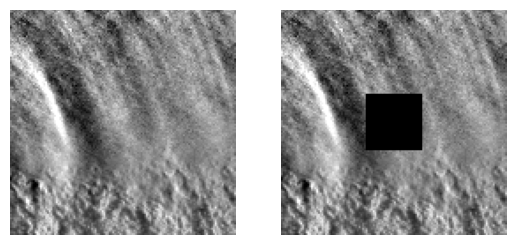

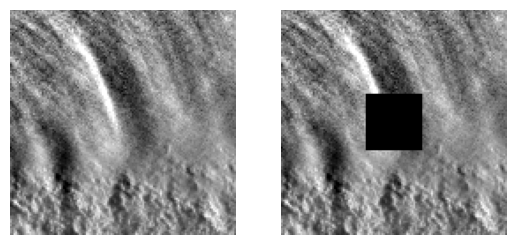

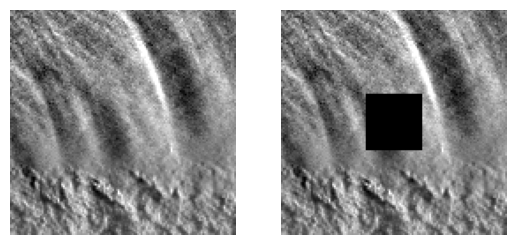

In [10]:
import matplotlib.pyplot as plt

vmax, vmin = np.array(frames).max(), np.array(frames).min()

for i, f in enumerate(frames):
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(f, cmap='gray', vmax=vmax, vmin=vmin)
    axs[0].axis('off')
    axs[1].imshow(f*~masks[i], cmap='gray', vmax=vmax, vmin=vmin)
    axs[1].axis('off')
    plt.show()

In [11]:
# inference
with torch.no_grad():
  current_feat, attn_dict, mm_dict = model.infer(feats[0], mask_tensors[0])
  current_img = torch.tanh(model.decoder(current_feat)).detach()
  pred_img = (current_img+1.)/2

In [12]:
for i, f in enumerate(chosen_frames):
    save_by_pyplt(np.squeeze(frame_tensors.cpu().numpy())[i], None, save_dir+'groundtruth_{}.jpg'.format(str(f).zfill(3)), 'gray')
    save_by_pyplt(np.squeeze(input_frames.cpu().numpy())[i], None, save_dir+'input_{}.jpg'.format(str(f).zfill(3)), 'gray')
    save_by_pyplt(np.squeeze(pred_img.cpu().numpy())[i], None, save_dir+'output_{}.jpg'.format(str(f).zfill(3)), 'gray')

In [13]:
for patch_size, attn in attn_dict.items():
    print("**********************************")
    print("Patch size: ", patch_size)
    print(attn.shape)
    for attender_idx in range(attn.shape[0]):
        attn_f = attn[attender_idx]
        attn_f = attn_f.cpu().numpy()
        attn_f = attn_f[0]
        avg_attention_to_frames = [attn_f[i].mean() for i in range(attn_f.shape[0])]
        # plt.bar(range(attn_f.shape[0]), avg_attention_to_frames)
        # plt.show()
    print()

**********************************
Patch size:  128
torch.Size([3, 1, 3, 1, 1])

**********************************
Patch size:  64
torch.Size([3, 4, 3, 2, 2])

**********************************
Patch size:  32
torch.Size([3, 16, 3, 4, 4])

**********************************
Patch size:  16
torch.Size([3, 64, 3, 8, 8])

**********************************
Patch size:  8
torch.Size([3, 256, 3, 16, 16])

**********************************
Patch size:  4
torch.Size([3, 1024, 3, 32, 32])



In [14]:
[mm.any() for _, mm in mm_dict.items()]

[tensor(False, device='cuda:0'),
 tensor(False, device='cuda:0'),
 tensor(False, device='cuda:0'),
 tensor(True, device='cuda:0'),
 tensor(True, device='cuda:0'),
 tensor(True, device='cuda:0')]

In [15]:
mm_dict[16][0,0]

tensor([[[False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False,  True,  True, False, False, False],
         [False, False, False,  True,  True, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False]],

        [[False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False,  True,  True, False, False, False],
         [False, False, False,  True,  True, False, False, False],
         [False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, F

In [35]:
import copy

patch_size = 4
# selected_patch=27#5
attn = copy.deepcopy(attn_dict[patch_size])
t, n_patches, _, _, _ = attn.shape

np_attn = attn.cpu().numpy()
n_patches = np_attn.shape[1]
t = np_attn.shape[0]

print(np_attn.shape)

(3, 1024, 3, 32, 32)


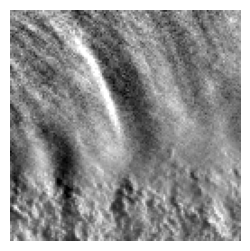

In [36]:
ncols = 3
nrows = int(np.ceil(n_patches/ncols))

fig, axs = plt.subplots(figsize=(3, 3))
axs.imshow(frames[1], cmap="gray")
axs.axis('off')
plt.show()


# fig, axs = plt.subplots(nrows, ncols, figsize=(3*ncols, 3*nrows))
# for i in range(n_patches):
#     ax = axs[i//ncols, i%ncols]
#     ax.imshow(np.squeeze(input_frames.cpu().numpy())[1], cmap="gray")
#     patch_rect = plt.Rectangle((i % (w // patch_size) * patch_size, i // (w // patch_size) * patch_size), patch_size, patch_size, linewidth=1, edgecolor='r', facecolor='none')
#     ax.add_patch(patch_rect)
#     ax.set_title(f"Patch {i}")
#     ax.axis('off')

plt.show()

In [37]:
# attn_results_path = save_dir+'attn_results/'
# os.makedirs(attn_results_path, exist_ok=True)

# vxtrm = np.max(np.abs(np_attn))

# attn_val = np_attn[1, selected_patch]

# for f in range(attn_val.shape[0]):
#     fig, axs = plt.subplots(figsize=(3,3))
#     axs.set_axis_off()

#     attn_val_rsh = cv2.resize(attn_val[f], (w, h), cv2.INTER_NEAREST)

#     axs.imshow(np.squeeze(input_frames.cpu().numpy())[f], cmap='gray')
#     axs.imshow(attn_val_rsh, alpha=0.7, cmap='viridis')

#     plt.tight_layout()
#     fig.savefig(attn_results_path+'attn_from_f{}_for_p{}.jpg'.format(f, selected_patch).zfill(3), dpi=200)        
#     plt.close(fig)

In [38]:
attn_results_path = save_dir+f'attn_results/f{target_frame}/ps{patch_size}/'
os.makedirs(attn_results_path, exist_ok=True)

vxtrm = np.max(np.abs(np_attn))

for i, f in enumerate(chosen_frames):
    for p in range(n_patches):
        attn_val = np_attn[1, p, i, ...]
        attn_val_rsh = cv2.resize(attn_val, (w, h), cv2.INTER_NEAREST)

        fig, axs = plt.subplots(1,2, figsize=(6,3))

        axs[0].imshow(np.squeeze(input_frames.cpu().numpy())[1], cmap="gray")
        patch_rect = plt.Rectangle((p % (w // patch_size) * patch_size, p // (w // patch_size) * patch_size), patch_size, patch_size, linewidth=1, edgecolor='r', facecolor='none')
        axs[0].add_patch(patch_rect)
        axs[0].set_axis_off()

        
        axs[1].imshow(np.squeeze(input_frames.cpu().numpy())[i], cmap="gray")
        # axs.imshow(attn_val_rsh, alpha=0.7, cmap='viridis', vmin=0, vmax=vxtrm)
        axs[1].imshow(attn_val_rsh, alpha=0.7, cmap='viridis')
        axs[1].set_axis_off()
        

        plt.tight_layout()
        fig.savefig(attn_results_path+'attn_from_f{}_for_p{}.jpg'.format(f, p).zfill(3), dpi=200)        
        plt.close(fig)

        # save_by_pyplt(np.squeeze(input_frames.cpu().numpy())[i], attn_val_rsh, attn_results_path+'attn_from_f{}_p{}.jpg'.format(f, p).zfill(3), None, vxtrm=vxtrm)